In [241]:
library(forecast)
library(ggplot2)

In [242]:
data=read.csv(file="Elec-train.csv",sep=";",header=TRUE,dec=",")

In [243]:
power=data[1:4507,2]
temp=data[1:4507,3]

In [244]:
powerTS1=ts(power,start=c(1,5),end=c(47,96),freq=96)
tempTS1=ts(temp,start=c(1,5),end=c(47,96),freq=96)

powerTS7=ts(power,start=c(1,6),end=c(7,480),freq=672)
tempTS7=ts(temp,start=c(1,6),end=c(7,480),freq=672)

In [245]:
temp_train1 = head(tempTS1,3552)
temp_test1 = tail(tempTS1,955)

power_train1 = head(powerTS1,3552)
power_test1 = tail(powerTS1,955)

temp_train7 = head(tempTS7,3552)
temp_test7 = tail(tempTS7,955)

power_train7 = head(powerTS7,3552)
power_test7 = tail(powerTS7,955)

## ARIMA / SARIMA models

**for period = 7 days the arima function is very slow and crash as soon as I try to put AR or MA on the seasonal pattern.So I have only worked with Period = 1 day**

**Check if the residuals are white noise ?**

In [246]:
Box.test(diff(power_train,lag=96),lag=100,type="Ljung-Box")


	Box-Ljung test

data:  diff(power_train, lag = 96)
X-squared = 7148.1, df = 100, p-value < 2.2e-16


I have taken a lag=700 to be sure to include a period.

**The p-value is very close to 0 so we can reject the fact to have a white noise**

We can start looking at an ARIMA/SARIMA model

### looking for a SARIMA model

First the automatique model :

In [248]:
fit4=auto.arima(power_train1)

In [249]:
fit4

Series: power_train1 
ARIMA(5,0,0)(0,1,0)[96] 

Coefficients:
         ar1     ar2      ar3      ar4     ar5
      0.7610  0.1098  -0.0203  -0.2647  0.1889
s.e.  0.0167  0.0206   0.0207   0.0206  0.0167

sigma^2 estimated as 90.84:  log likelihood=-12693.62
AIC=25399.23   AICc=25399.26   BIC=25436.12

**The selected model is order(5,0,0) seasonal(0,1,0)**

In [250]:
for4=forecast(fit4,h=955)
print(sqrt(mean((for4$mean-power_test1)^2)))

[1] 16.21047


**The MSE is : 16.21047 Let's see if we can improve manually**

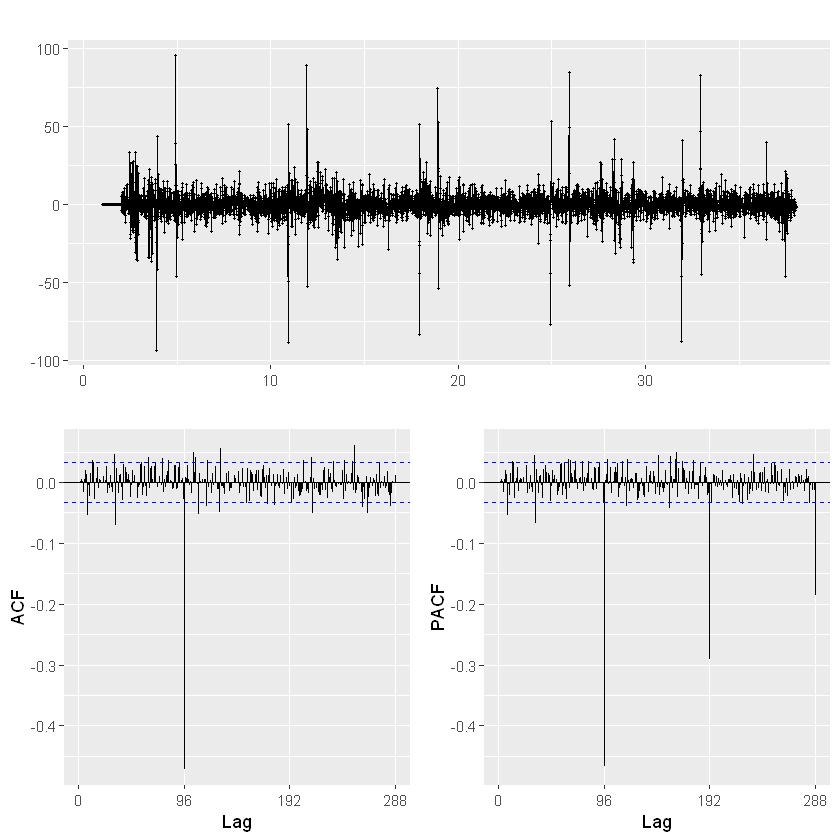

In [251]:
fit4 %>% residuals() %>% ggtsdisplay()

We can see autocorrelation link with the week periodic effect.

See if we can lower these picks by adding a moving average at the seasonal effect

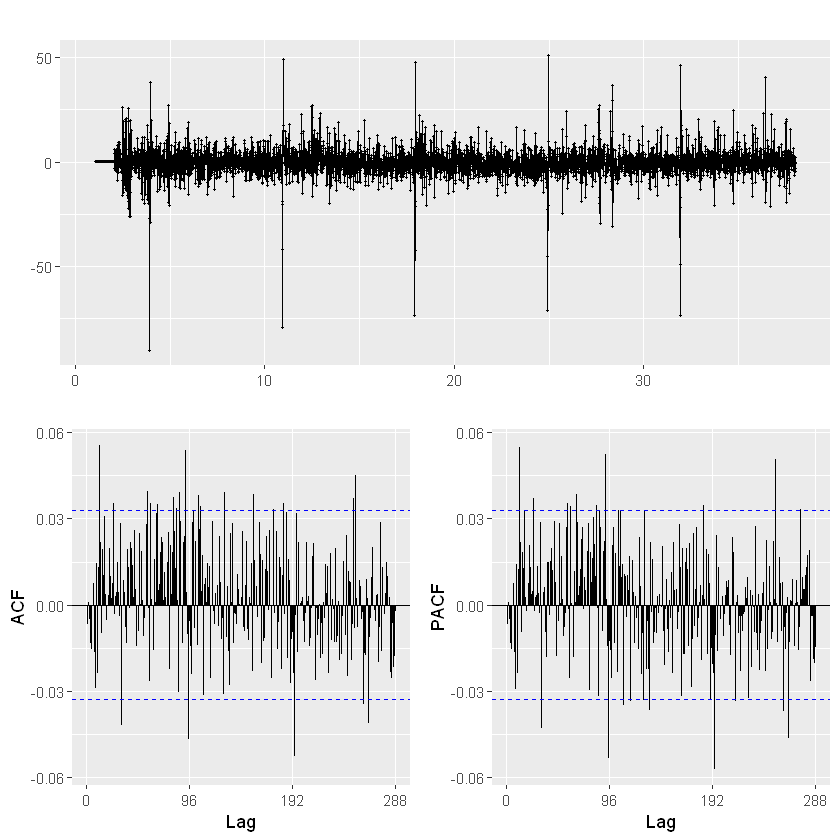

In [252]:
fit4=Arima(power_train1, order=c(5,0,0), seasonal=c(0,1,1) )
fit4 %>% residuals() %>% ggtsdisplay()

In [253]:
for4=forecast(fit4,h=955)

In [254]:
print(sqrt(mean((for4$mean-power_test1)^2)))

[1] 14.72462


**The graph is better and the MSE of 14.72 is better**

Unfortunetly I can't go further for each other improvment I tried the arima function returns an error.

**So I will keep this result which has a MSE bigger then the exponential smoothing one**

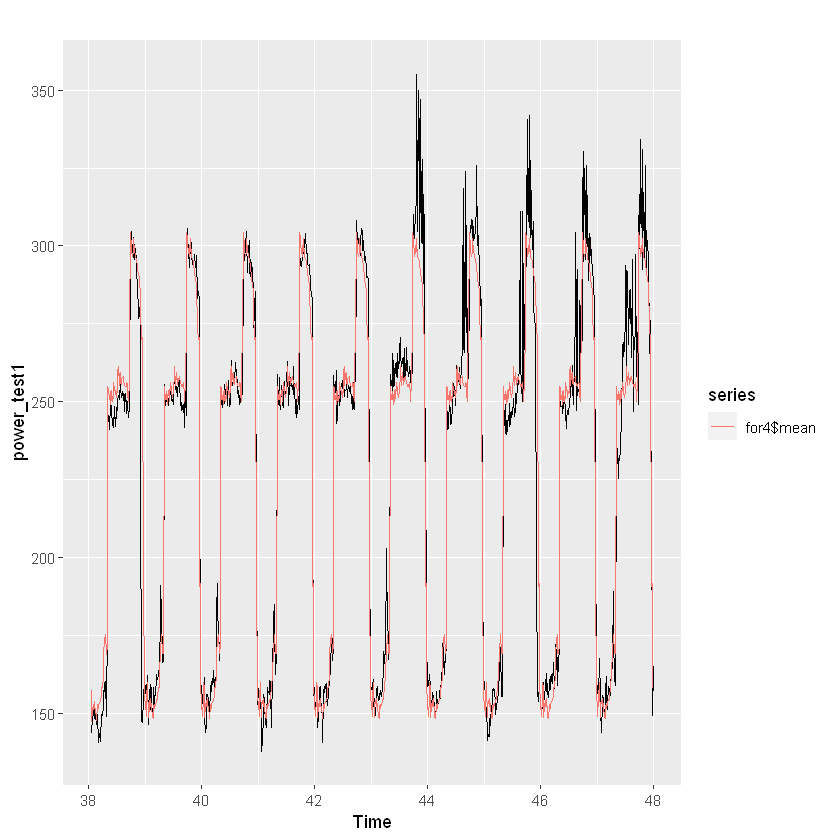

In [255]:
autoplot(power_test1)+autolayer(for4$mean)

### Arima model with variation change

The  model above is tested with an automatic BoxCox parameter to see if there is a significant improve

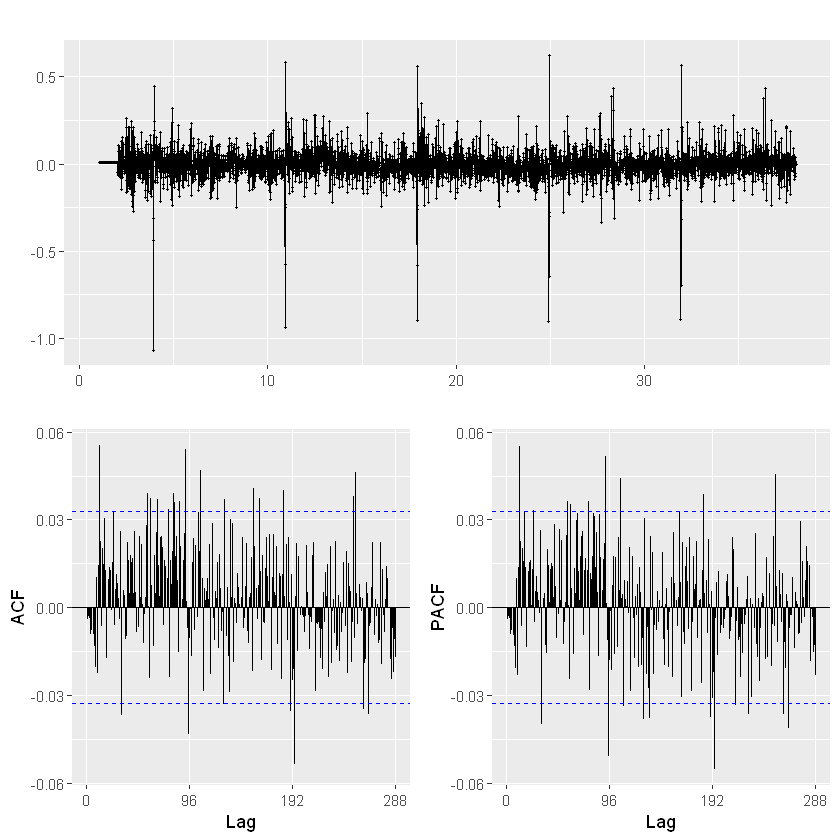

In [256]:
fit4=Arima(power_train1, order=c(5,0,0), seasonal=c(0,1,1), lambda = 'auto' )
fit4 %>% residuals() %>% ggtsdisplay()

In [257]:
for4=forecast(fit4,h=955)

In [258]:
print(sqrt(mean((for4$mean-power_test1)^2)))

[1] 14.66297


**With variation change the MSE result is better but not significantly**

### ARIMA/SARIMA with temperature data taken into account

**First have a look at the relation between power and temperature**

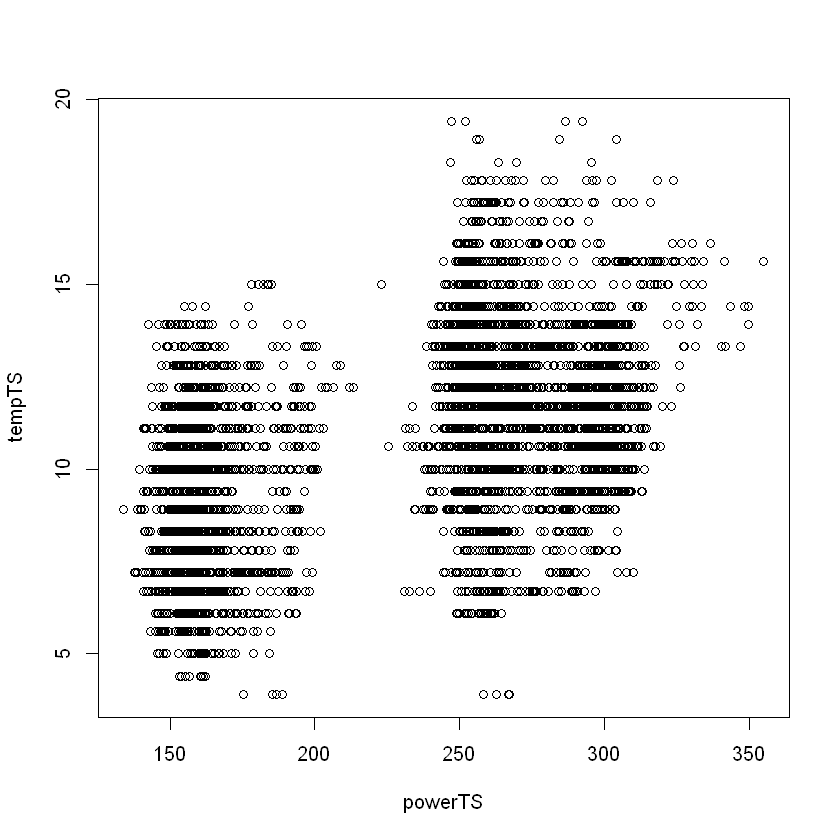

In [259]:
plot(powerTS,tempTS)

We can imagine some link but the correlation is not obvious

**So I am looking if there is a possible linear effect of the temperature data on the forecasting of the power**

In [260]:
fit11=tslm(power_train1~temp_train1+trend+season)
summary(fit11)


Call:
tslm(formula = power_train1 ~ temp_train1 + trend + season)

Residuals:
     Min       1Q   Median       3Q      Max 
-113.584   -4.497    0.225    4.520   59.155 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.554e+02  2.081e+00  74.675  < 2e-16 ***
temp_train1  1.170e+00  9.679e-02  12.091  < 2e-16 ***
trend       -5.140e-03  1.913e-04 -26.875  < 2e-16 ***
season2     -6.233e+00  2.646e+00  -2.356  0.01853 *  
season3      3.454e-01  2.646e+00   0.131  0.89613    
season4      3.626e+00  2.646e+00   1.371  0.17056    
season5      3.600e+00  2.646e+00   1.361  0.17365    
season6     -5.622e+00  2.646e+00  -2.125  0.03367 *  
season7     -6.000e+00  2.646e+00  -2.268  0.02339 *  
season8     -2.368e+00  2.646e+00  -0.895  0.37081    
season9     -3.503e+00  2.646e+00  -1.324  0.18564    
season10    -8.569e-01  2.646e+00  -0.324  0.74605    
season11    -1.538e+00  2.646e+00  -0.581  0.56101    
season12     3.534e-01  2.646e+00   0.134  0

All the features seems significant
I check the residuals


	Breusch-Godfrey test for serial correlation of order up to 192

data:  Residuals from Linear regression model
LM test = 2241.7, df = 192, p-value < 2.2e-16


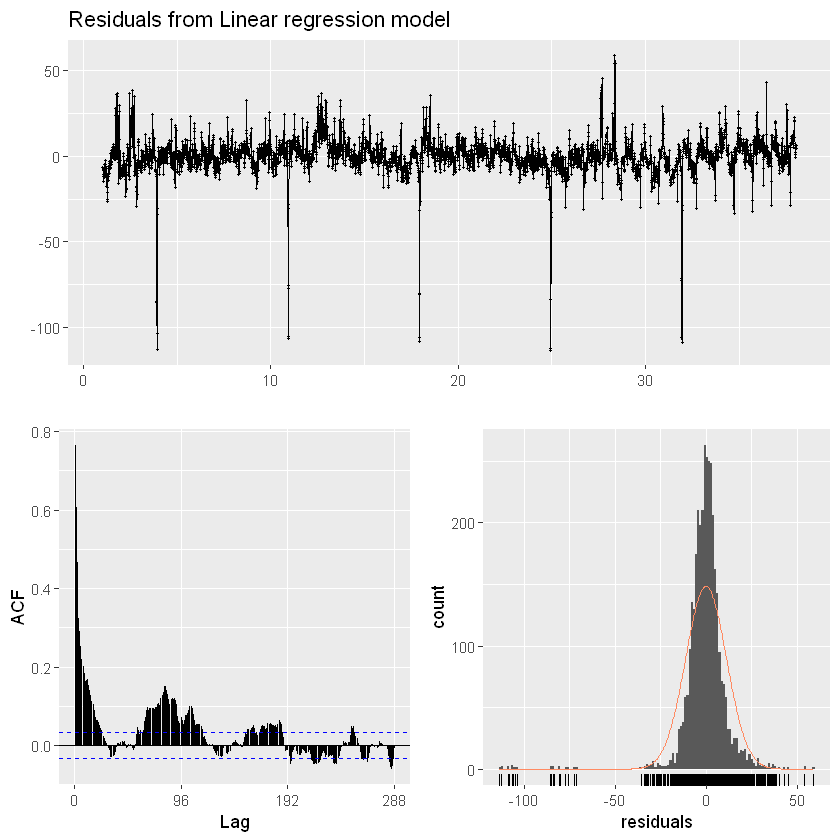

In [261]:
checkresiduals(fit11)

Let's look at the autocorrelations

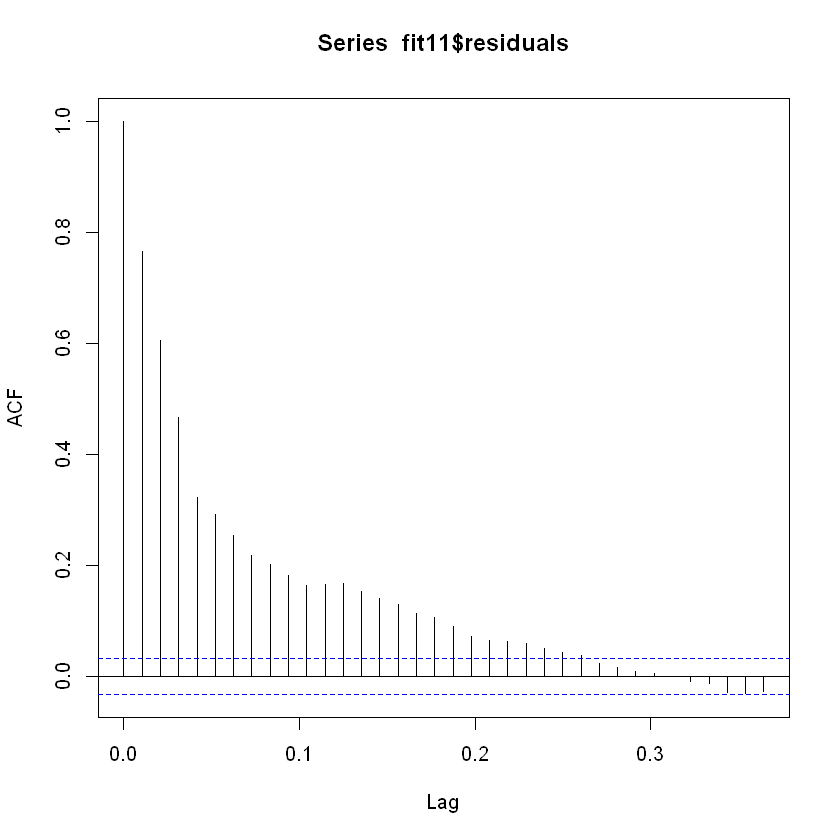

In [262]:
plot(acf(fit11$residuals))

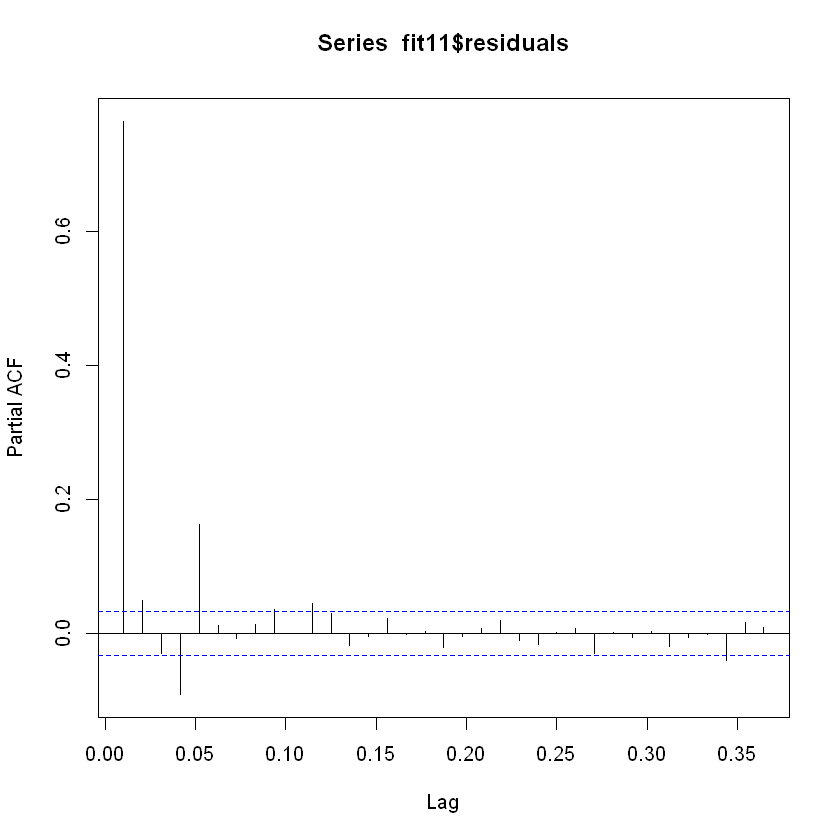

In [263]:
plot(pacf(fit11$residuals))

The ACP and PACF look like those of an AR5 model: exponential deacrease of the ACF and significant
PCA at lag 5. We can test it:


	Ljung-Box test

data:  Residuals from ARIMA(5,0,0) with non-zero mean
Q* = 306.11, df = 186, p-value = 6.756e-08

Model df: 6.   Total lags used: 192



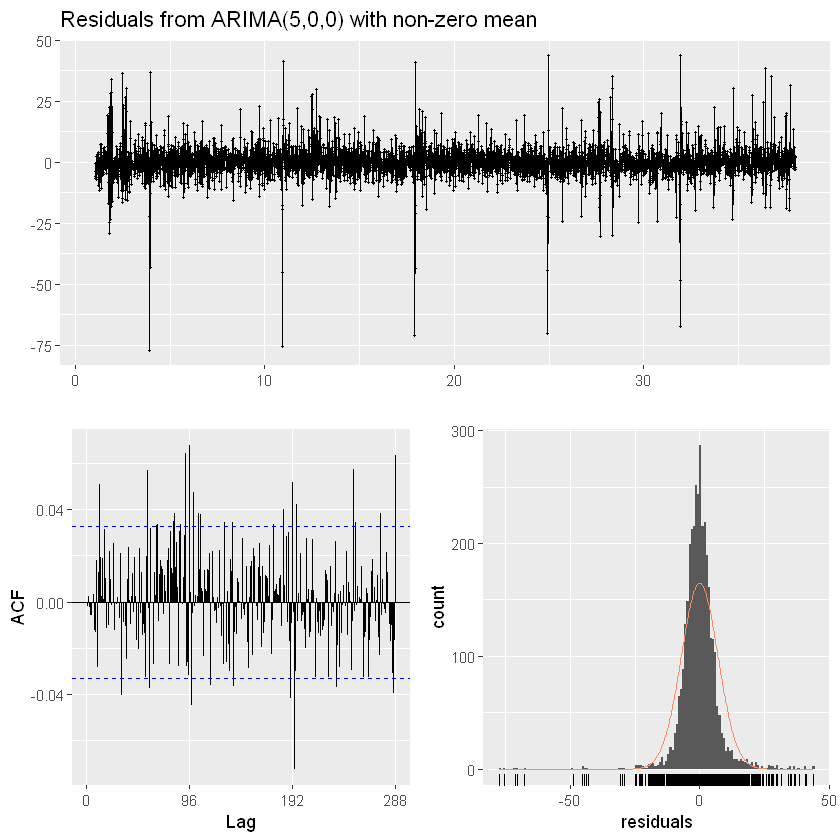

In [264]:
tmp=fit11$residuals
fit12=Arima(tmp,order=c(5,0,0))
checkresiduals(fit12)

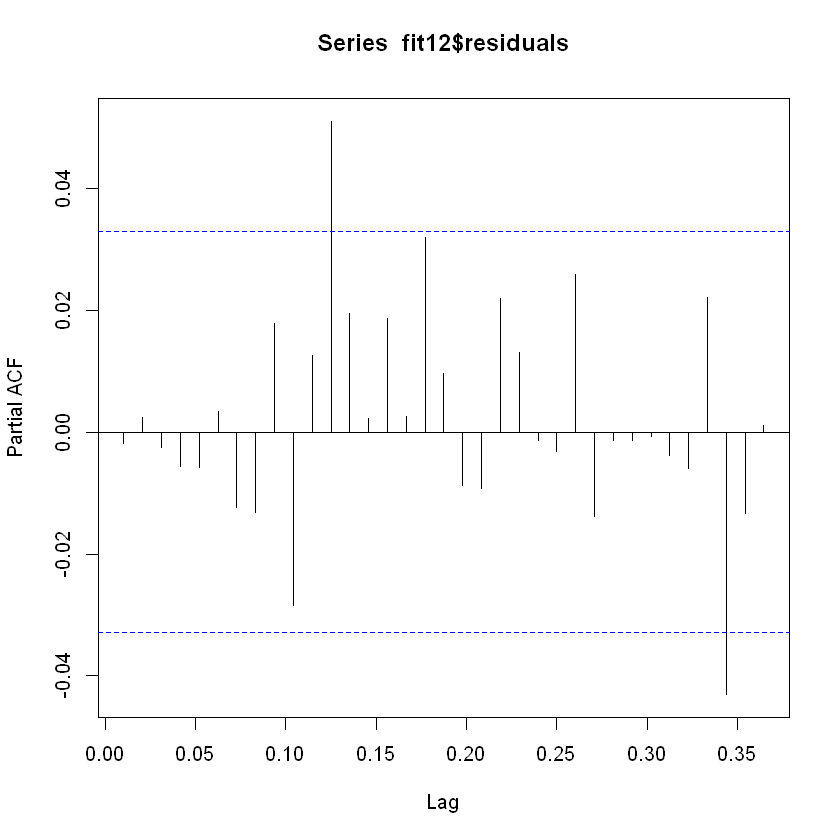

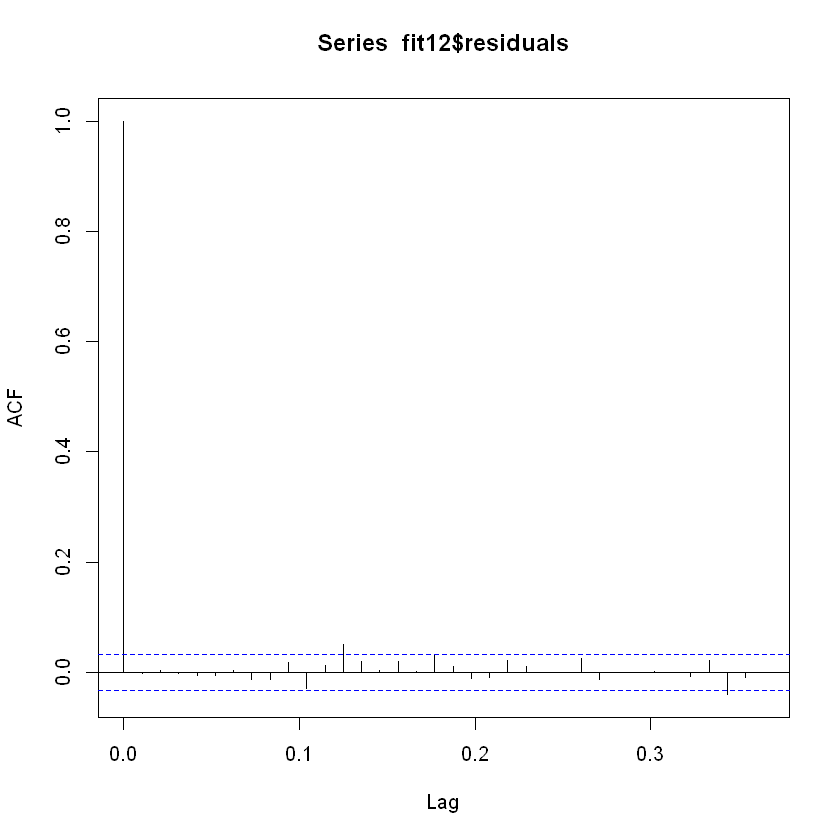

In [265]:
plot(pacf(fit12$residuals))
plot(acf(fit12$residuals))

So the model could be

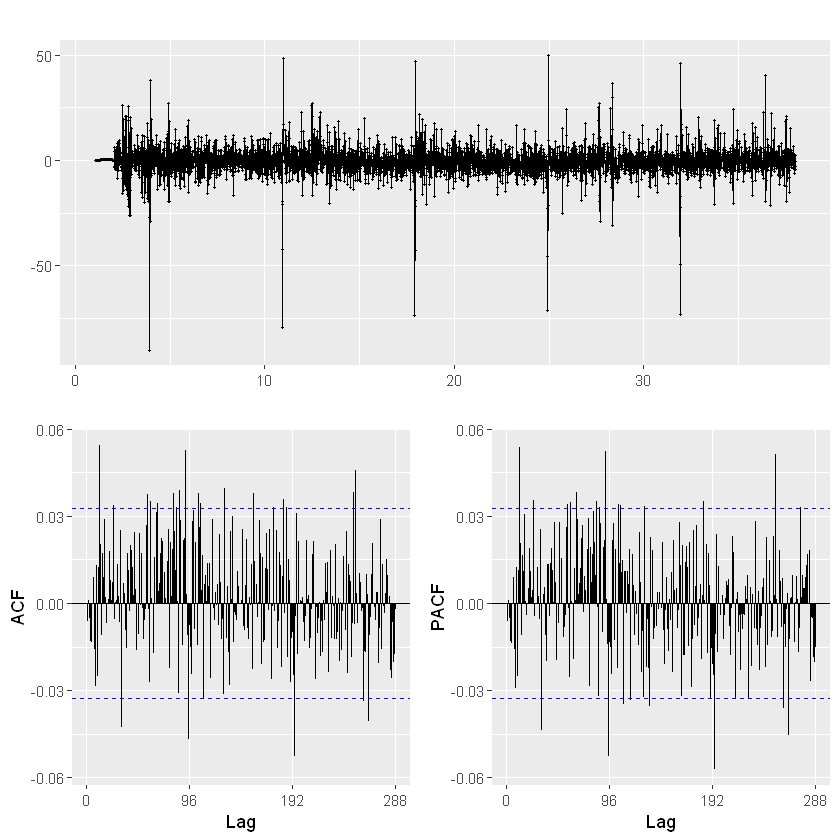

In [266]:
fit13=Arima(power_train1,xreg = temp_train1, order=c(5,0,0), seasonal=c(0,1,1))
fit13 %>% residuals() %>% ggtsdisplay()


	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,0,0)(0,1,1)[96] errors
Q* = 259.64, df = 185, p-value = 0.000243

Model df: 7.   Total lags used: 192



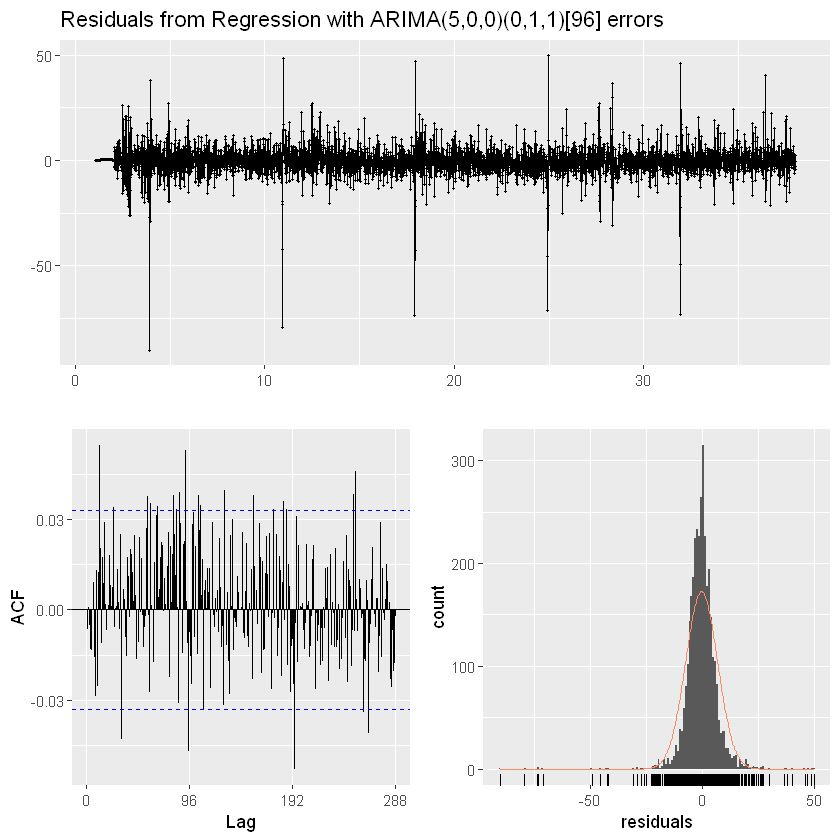

In [267]:
checkresiduals(fit13)

**As before there are still correlation on the residuals but I can't improve it because if I increase the AR or MA on seasonal effect the Arima function is on error.**

So I am using this to do my forecast on test set

In [268]:
for13=forecast(fit13,h=955,xreg=temp_test1)

In [269]:
print(sqrt(mean((for13$mean-power_test1)^2)))

[1] 14.53399


**The MSE : 14.53  is better then without the covariate but still not as good as exponential smoothing**

## Neural network model

### with seasonal Period = 1 day

In [270]:
fit8=nnetar(power_train1)
print(fit8)

Series: power_train1 
Model:  NNAR(20,1,11)[96] 
Call:   nnetar(y = power_train1)

Average of 20 networks, each of which is
a 21-11-1 network with 254 weights
options were - linear output units 

sigma^2 estimated as 49.18


**The network (20,1,11) is selected**

In [271]:
for8=forecast(fit8,h=955)

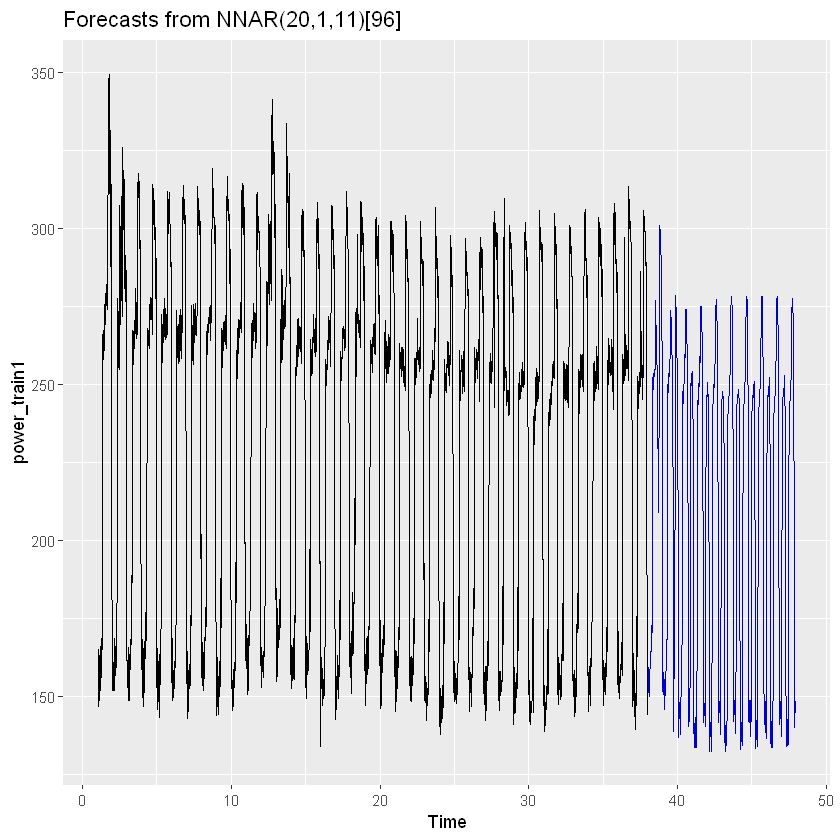

In [272]:
autoplot(for8)

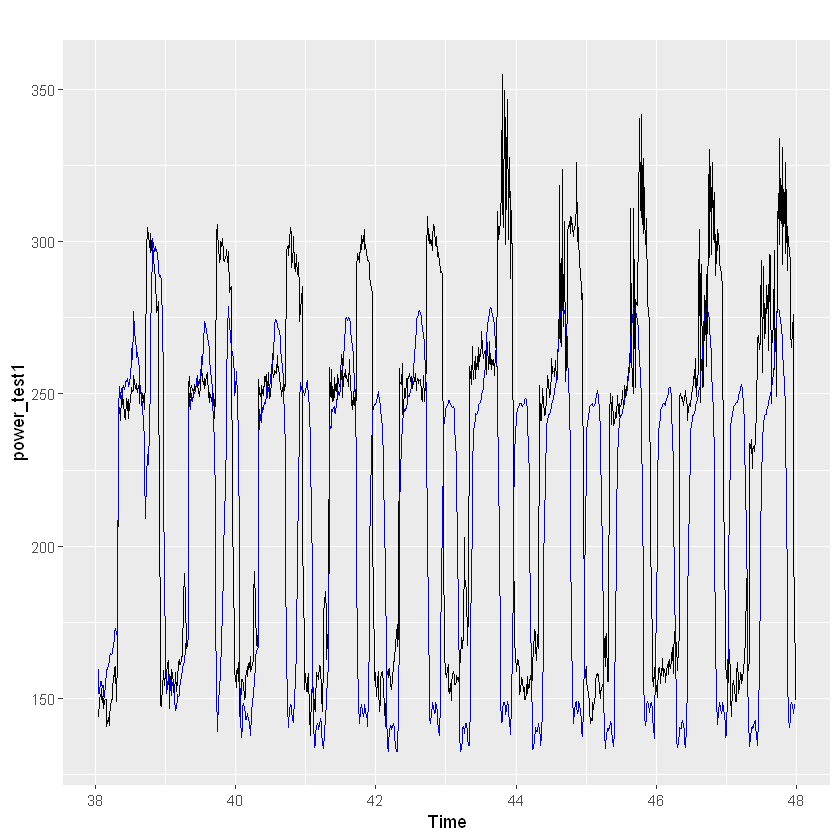

In [273]:
autoplot(power_test1)+autolayer(for8)

In [274]:
print(sqrt(mean((for8$mean-power_test1)^2)))

[1] 72.57276


**The MSE for Neural network is 72.57 with period = 1 day**

### with seasonal Period = 7 day

In [277]:
fit8=nnetar(power_train7)
print(fit8)

Series: power_train7 
Model:  NNAR(17,1,10)[672] 
Call:   nnetar(y = power_train7)

Average of 20 networks, each of which is
a 18-10-1 network with 201 weights
options were - linear output units 

sigma^2 estimated as 30.54


**The network (17,1,11) is selected**

In [278]:
for8=forecast(fit8,h=955)

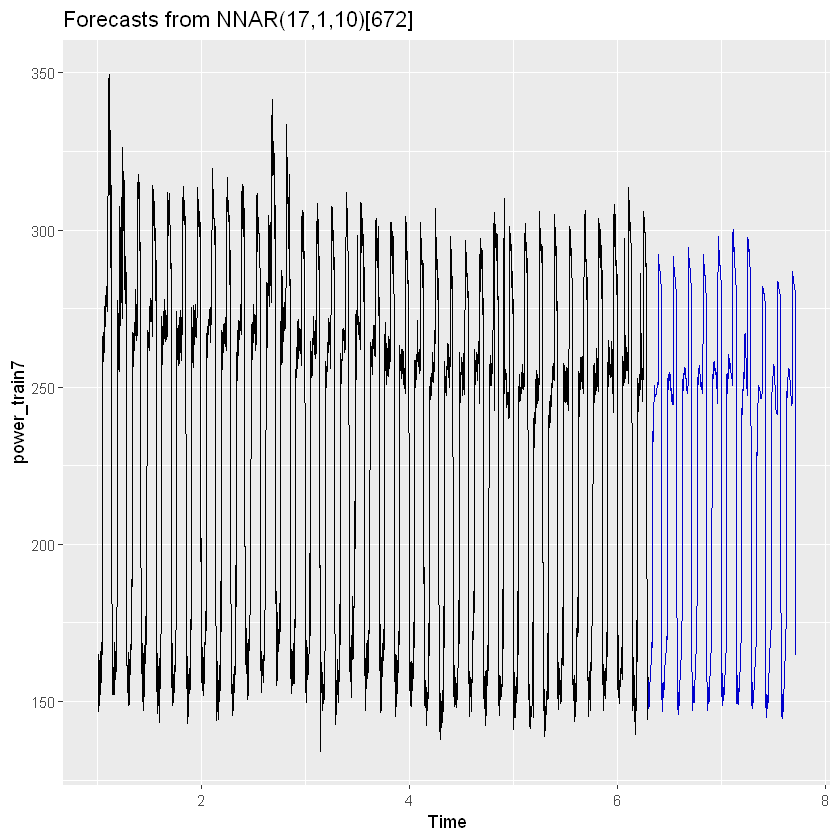

In [279]:
autoplot(for8)

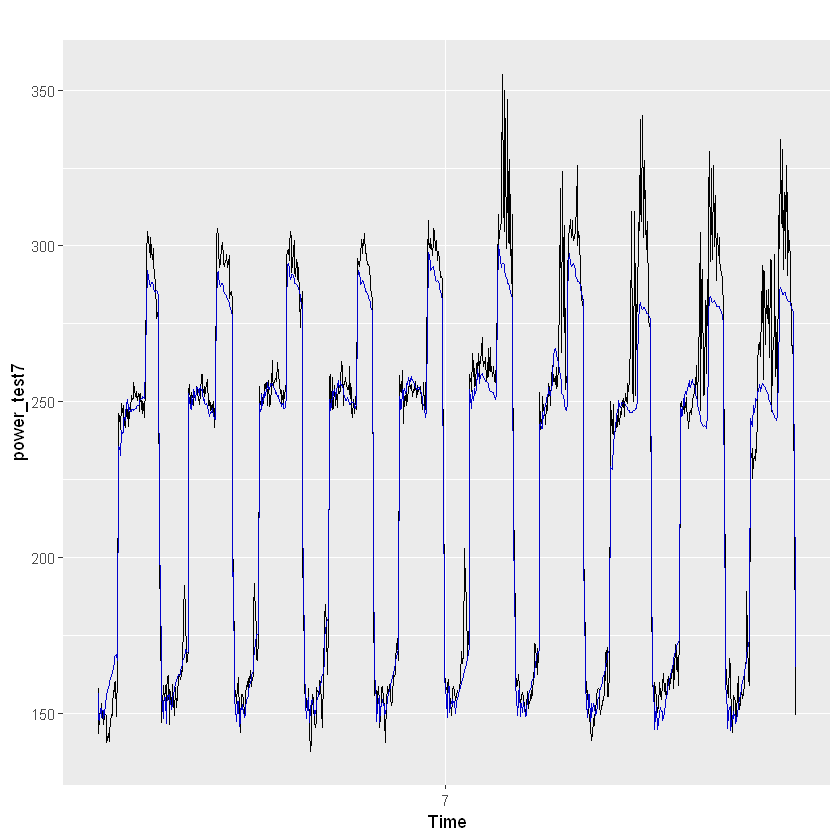

In [280]:
autoplot(power_test7)+autolayer(for8)

In [282]:
print(sqrt(mean((for8$mean-power_test7)^2)))

[1] 13.30664


**The MSE for Neural network is 13.30 with period = 7 day**

## Neural network model with use of the temperature

In [283]:
fit24=nnetar(power_train7,xreg=temp_train7 )
print(fit24)

Series: power_train7 
Model:  NNAR(17,1,10)[672] 
Call:   nnetar(y = power_train7, xreg = temp_train7)

Average of 20 networks, each of which is
a 19-10-1 network with 211 weights
options were - linear output units 

sigma^2 estimated as 29.72


**The network (17,1,11) is selected**

In [284]:
for24 = forecast(fit24,xreg=temp_test7,h=955)
print(sqrt(mean((for24$mean-power_test7)^2)))

[1] 13.22897


**When taking in account the temperature, the MSE for Neural network is 13.23 with period = 7 day**

# Choice of the modele for prediction

**Among all the models the best result is obtained with exponential smoothing with additive effect, so I will use this model for the prediction**

**For the prediction with temperature even if no model "with temperature has done better then the exponential smoothing "without temperature" I will try the neural network "with temperature"**

## Prediction without temperature

In [290]:
fit1=HoltWinters(powerTS7,alpha=NULL,beta=NULL,gamma=NULL)
p1 = predict(fit1,n.ahead=96)

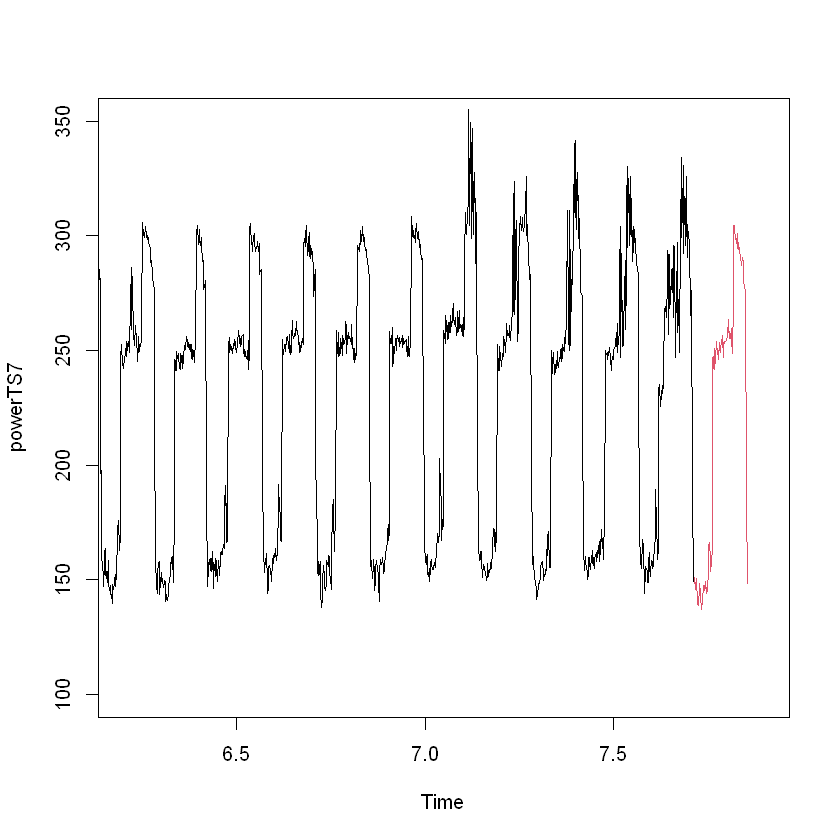

In [291]:
plot(powerTS7,xlim=c(6.2,7.9),ylim=c(100,350))
lines(p1[,1],col=2)

## Prediction with temperature

In [293]:
fit2=nnetar(powerTS7,xreg=tempTS7 )
print(fit24)

Series: powerTS7 
Model:  NNAR(17,1,10)[672] 
Call:   nnetar(y = powerTS7, xreg = tempTS7)

Average of 20 networks, each of which is
a 19-10-1 network with 211 weights
options were - linear output units 

sigma^2 estimated as 36.64


In [299]:
for2 = forecast(fit2,xreg=data[4508:4603,3],h=96)

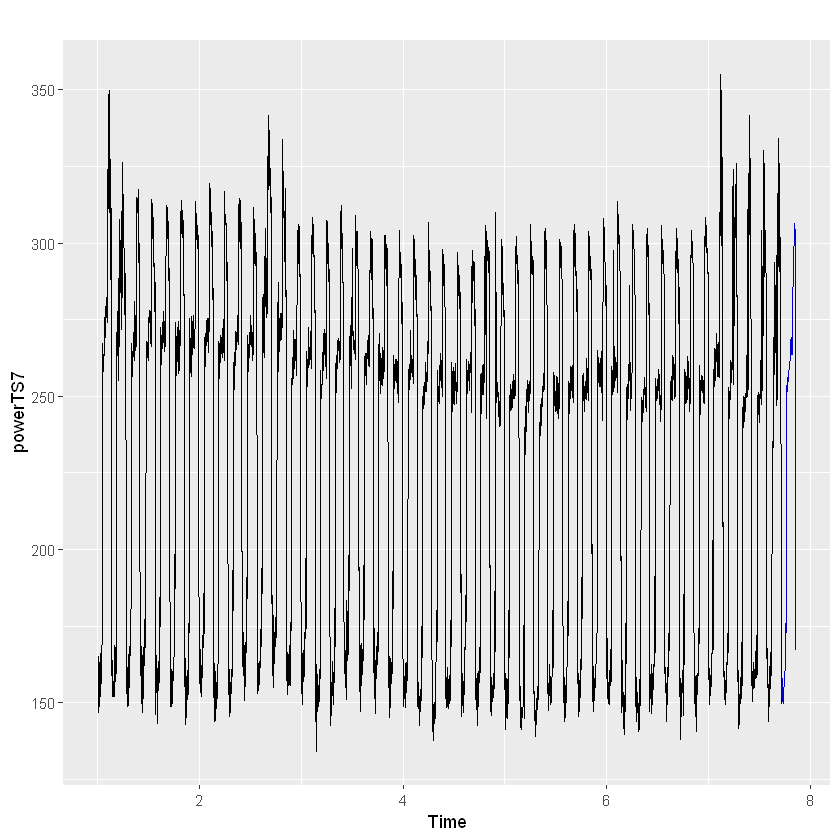

In [300]:
autoplot(powerTS7)+autolayer(for2)

In [301]:
out=data.frame(p1,for2$mean)

In [304]:
write.csv(out,file="Exam.csv")

In [303]:
out

fit,for2.mean
<dbl>,<ts>
148.2830,151.6589
150.9542,156.2425
145.9231,151.7987
147.3029,156.8987
150.6298,157.4110
150.8677,157.9106
139.5407,150.3678
138.8379,151.3630
141.5547,152.6361
